In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn import metrics

sns.set(style="whitegrid", context="paper")

In [3]:
read_jsonl = lambda p: pd.read_json(p, orient="records", lines=True)

In [7]:
dfs = {}
for p in glob("./*.jsonl"):
    dfs[p] = read_jsonl(p)

In [11]:
dfsk = list(dfs.keys())

In [13]:
for k in dfsk:
    if "yelp" in k:
        dfs[k]["dataset"] = "Yelp"
    elif "ylzg" in k:
        dfs[k]["dataset"] = "Tw y=Loc z=Gender"
    elif "spam" in k:
        dfs[k]["dataset"] = "Spam"

In [107]:
df_spam = pd.concat([dfs[_] for _ in dfsk if "spam" in _], ignore_index=True)

In [108]:
df_spam

,model,result,dataset
0,LR,"[0.915403422982885, 0.976773160096111, 0.96209...",Spam
1,ABOW_Z_hat,"[0.9479905437352241, 0.9845573711617881, 0.977...",Spam
2,ABOW_Domain_Adaptation,"[0.8794237394300031, 0.9786019971469321, 0.900...",Spam
3,DNN,"[0.9865391427559331, 0.9883126369612851, 0.981...",Spam
4,LR,"[0.8702500000000001, 0.967375, 0.9474166666666...",Spam
5,ABOW_Z_hat,"[0.923, 0.9785, 0.9691666666666661, 0.97106249...",Spam
6,ABOW_Domain_Adaptation,"[0.8075, 0.97, 0.8518333333333331, 0.9269375, ...",Spam
7,DNN,"[0.981, 0.984, 0.975333333333333, 0.972625, 0....",Spam


In [109]:
flat_spam_res = []
for i, r in df_spam.iterrows():
    for res in r.result:
        flat_spam_res.append(dict(model=r.model, f1=res, dataset=r.dataset))
new_df_spam = pd.DataFrame(flat_spam_res)

In [110]:
df = pd.concat([dfs[_] for _ in dfsk if "spam" not in _ and "zhat" not in _], ignore_index=True)
df["corr_diff"] = (df.tr_corr - df.te_corr).abs().round(1)
df = df[df.corr_diff > .8]
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df = pd.concat([df, new_df_spam], ignore_index=True)
df["model"] = df.model.str.lower()
df.model.replace("abow_domain_adaptation", "abow_da", inplace=True)


/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [111]:
df.model.value_counts()

lr             14
abow_z_hat     14
dnn            14
abow_da        14
abow_z_true     4
Name: model, dtype: int64

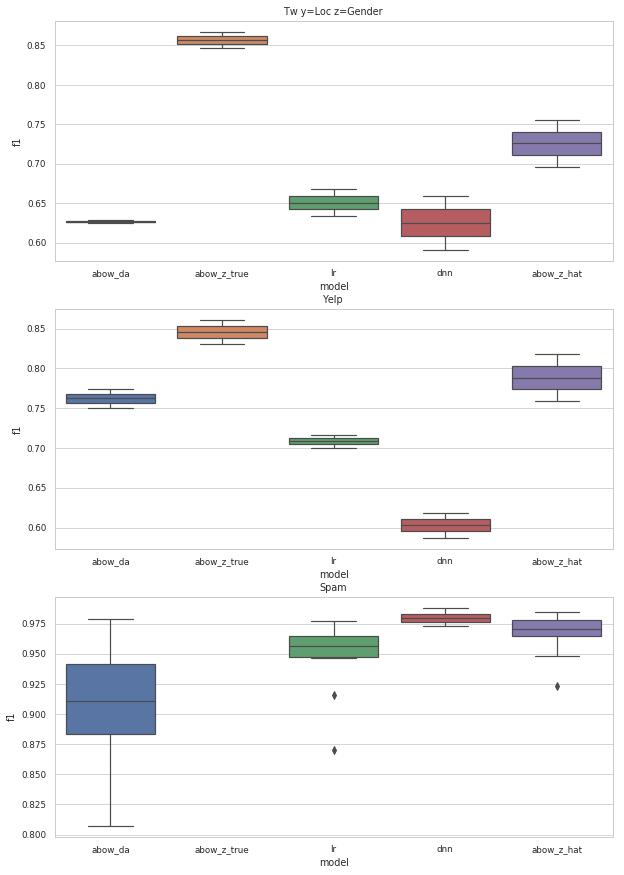

In [70]:
n_datasets = df.dataset.nunique()
fig, ax = plt.subplots(n_datasets, sharex=False, figsize=(10, n_datasets*5))
order = df.groupby("model").mean().f1.sort_values().index.tolist()

for i, dname in enumerate(df.dataset.unique()):
    dfi = df[df.dataset==dname]
    axi = ax[i] if n_datasets > 1 else ax
    sns.boxplot("model", "f1", data=dfi, ax=axi, order=order)
    axi.set_title(dname)
fig.savefig("benchmark.pdf", bboxes_inches="tight")

In [146]:
from collections import defaultdict
n_datasets = df.dataset.nunique()
r = defaultdict(dict)
t = "${:.3f} \pm {:.3f}$"
for i, dname in enumerate(df.dataset.unique()):
    dfi = df[df.dataset==dname]
    g = dfi.groupby("model").f1
    m = g.mean()
    s = g.std()
    for k in m.keys():
        r[dname][k] = t.format(m[k], s[k])

In [147]:
df_latex = pd.DataFrame(r)

In [148]:
df_latex.index = ["Adv+DA", "Adv+\hat{Z}", "Adv+Z (Oracle)", "DNN", "LR"]

In [149]:
from IPython.display import display_latex

In [150]:
print(df_latex.to_latex(bold_rows=True, escape=False))

\begin{tabular}{llll}
\toprule
{} &  Tw y=Loc z=Gender &               Yelp &               Spam \\
\midrule
\textbf{Adv+DA        } &  $0.627 \pm 0.003$ &  $0.763 \pm 0.017$ &  $0.908 \pm 0.053$ \\
\textbf{Adv+\hat{Z}   } &  $0.726 \pm 0.042$ &  $0.788 \pm 0.041$ &  $0.966 \pm 0.018$ \\
\textbf{Adv+Z (Oracle)} &  $0.857 \pm 0.014$ &  $0.846 \pm 0.021$ &                NaN \\
\textbf{DNN           } &  $0.625 \pm 0.049$ &  $0.603 \pm 0.022$ &  $0.980 \pm 0.005$ \\
\textbf{LR            } &  $0.651 \pm 0.025$ &  $0.709 \pm 0.011$ &  $0.946 \pm 0.032$ \\
\bottomrule
\end{tabular}



In [78]:
g.mean().to_dict()

{'abow_da': 0.9079828542875854,
 'abow_z_hat': 0.9663938024154488,
 'dnn': 0.9799261201879588,
 'lr': 0.9463908117419614}